# The project

In this project we use custom Neural Networks to perform an homeomorphism which will aim to transform representations of the same data to make them more similar.

For this we :

1) Scrap Wikipedia and :
    - Extract features from the text to have one representations of them
    - Extract the categories of the articles to have another space representation
2) We create a neural network with a custom shape and a custom loss function for it to be minimized
3) We assess the performance of our algorithm
 

# Creating the Neural Network

## The theoretical aim

We consider here two different ways to generate a topology.
1) A topology induced by a metric
    - A topology $\mathcal{T}$ is induced by a metric function $d$ applied over a set of elements $\mathcal{A}$ 
    - We have here two sets $\mathcal{A}_{text}$ and $\mathcal{A}_{categories}$ and we consider the same metric function over the two spaces.
    - Thus, in order to have the same topology, $\mathcal{A}_{text}$ and $\mathcal{A}_{categories}$ must be identical.
    - Our Neural Network will aim to find the function performing the transformation of the textual features mapping them as close as possible to the categories vectors
2) A topology by neighbouhood
    - A topology can also be understood through the neihbourhood function. If every vector in the set $\mathcal{A}_{text}$ has the same neighbours as in the set $\mathcal{A}_{categories}$
    - Thus our Neural Network will aim to make the categorical neighbours closer than the non neighbours in the textual vector space $\mathcal{A}_{text}$ 

## The basic Neural Network Architecture

- Our Neural Network will take two inputs
    - A) Vectors from $\mathcal{A}_{text}$
    - B) Vectors from $\mathcal{A}_{categories}$
- Each input goes though its path
    - A) A multi-layer perceptron 
    - B) An embedding layer
- The loss is computed as follow:
    - 1) The pairwise distance of every vectors outputed by the two pathes is computed
    - 2) The correlation between the two pairwise distances are computed

The path "A" is longer than the path "B" because we consider the categorical topology to be a noisy `*Ground Truth*', thus we do not allow much transformation of the input in the path "B".

We also Normalize the last layer, for not the Neural Network to find the trivial solution where every vectors are nuls.

![alt text](DoubleEmbedding_induced.png "Neural Network Architecture")

In [124]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt 

BAD_ARTICLE = 'Wang Yun (Dynastie Yuan)'

path_global = "/Users/jean-baptistechaudron/Documents/Thèse/Coffre Fort Thèse"

df_text = pd.read_parquet(path_global+"/df_train_wiki_out.parquet.gzip")
df_categories = pd.read_parquet(path_global+"/Wikipedia_categories_labelling_smoothed.parquet.gzip")

df_text = df_text.fillna(0)
df_categories = df_categories.fillna(0)
# We remove an article which had some problems
df_text = df_text.loc[[x for x in df_text.index if not x == BAD_ARTICLE],:]
df_categories = df_categories.loc[[x for x in df_categories.index if not x == BAD_ARTICLE],:]

# We preprocess the categories
tsvd = TruncatedSVD(500).fit(df_categories)


KeyboardInterrupt: 

450


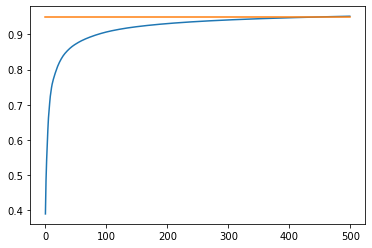

In [ ]:
import numpy as np 

n_comp = sum(np.cumsum(tsvd.explained_variance_ratio_)<0.95)
print(n_comp)
val = np.cumsum(tsvd.explained_variance_ratio_)[n_comp]
plt.plot(np.cumsum(tsvd.explained_variance_ratio_))
plt.plot(list(range(0,500)),[val for _ in range(500)])


In [ ]:
df_categories = pd.DataFrame(TruncatedSVD(n_comp).fit_transform(df_categories),
                             index=df_categories.index)

In [142]:
index_train, index_test = train_test_split(np.unique([x for x in df_text.index if x in df_categories.index]),
                                           train_size=0.6,
                                           shuffle=True,
                                           random_state=2060954)
#index_test, index_val = train_test_split(index_test,
#                                           train_size=0.4,
#                                           shuffle=True,
#                                           random_state=2060954)
"""
X_train, X_test, y_train, y_test = train_test_split(df_text, df_categories,
                                                    train_size=0.7, shuffle=True,
                                                    random_state=2060954)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,
                                                train_size=0.7, shuffle=True,
                                                random_state=2060954)
"""

X_train, X_test, X_val = df_text.loc[index_train,:], df_text.loc[index_test,:], df_text.loc[index_test,:]
y_train, y_test, y_val = df_categories.loc[index_train,:], df_categories.loc[index_test,:], df_categories.loc[index_test,:]


## Data Preparation

We need now to create our DataLoader for the training of the Neural Network.
In Pytorch a dataset class must implement two functions
* __len__ : Which gives the length of the dataset we will use
* __getitem__ : Which, given an index value, return the input, output and every parameter needed for one iteration of the training of our Neural Network

In the __init__ function we generate our dataset, then the __getitem__ go fetch the data in the dataset

In [143]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np 
import random 
from scipy.stats import rankdata 

class Double_embedding_dataset_neighbors(Dataset):

    def __init__(self, labels, data, label_distance, n_sample,k=15):
        self.labels = labels
        self.data = data
        self.label_distance= label_distance
        self.n_sample=n_sample
        self.gen_XY_neighbors(k=k)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self,idx):
        return self.X[idx], self.y[idx], self.X_neighbors[idx],self.y_neighbors[idx], self.X_contrefactual[idx], self.y_contrefactual[idx]

    def gen_XY_neighbors(self,k=15):
        """
            The generator of the dataset work as follow
            1 - We rank the data in terms of Y values
                We select random values of y to be paired with a given y
            2 - We select the K-best y value for each y values
                We create the vector of best value and random ones
            3 - We select, given the same indices, the random and good values of X
        """
        np.fill_diagonal(self.label_distance,10_000)
        rank_y = rankdata(self.label_distance,axis=1,method="ordinal")
        rand_idx = [random.sample(list(range(rank_y.shape[1])),k=k) for _ in range(rank_y.shape[0])]
        
        y_numpy = self.labels.to_numpy()
        k_best_y = np.array([y_numpy[ranks<k+1].astype(float) for ranks in rank_y])
        k_random_y = np.array([y_numpy[idx].astype(float) for idx in rand_idx])

        datas = self.data.loc[self.labels.index,:]
        k_best_x = np.array([datas.iloc[ranks<k+1,:].to_numpy().astype(float) for ranks in rank_y])
        k_random_x = np.array([datas.iloc[idx].to_numpy().astype(float) for idx in rand_idx])

        print(k_best_x.shape, k_best_y.shape)
        self.X, self.y = torch.unsqueeze(torch.Tensor(datas.to_numpy()).to(torch.float32),1),torch.unsqueeze(torch.Tensor(self.labels.to_numpy()).to(torch.float32),1)
        self.y_neighbors, self.y_contrefactual = torch.Tensor(k_best_y).to(torch.float32), torch.Tensor(k_random_y).to(torch.float32)
        self.X_neighbors, self.X_contrefactual = torch.Tensor(k_best_x).to(torch.float32), torch.Tensor(k_random_x).to(torch.float32)


In [144]:
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform

MMS = MinMaxScaler()

dataset = Double_embedding_dataset_neighbors(y_train.fillna(0)
                                             ,pd.DataFrame(MMS.fit_transform(X_train),index=X_train.index,columns=X_train.columns),
                                             squareform(pdist(y_train.to_numpy(),metric="jaccard")),
                                             100_000,
                                             k=15)

validation_dataset = Double_embedding_dataset_neighbors(y_val.fillna(0),
                                                        pd.DataFrame(MMS.transform(X_val), index= X_val.index, columns=X_val.columns),
                                                        squareform(pdist(y_val.to_numpy(),metric="jaccard")),
                                                        50_000,
                                                        k=15)

test_dataset = Double_embedding_dataset_neighbors(y_test.fillna(0),
                                                  pd.DataFrame(MMS.transform(X_test),index=X_test.index,columns=X_test.columns),
                                                  squareform(pdist(y_test.to_numpy(),metric="jaccard")),
                                                  50_000,
                                                  k=15)


(11378, 15, 79) (11378, 15, 450)
(7583, 15, 79) (7583, 15, 450)
(7583, 15, 79) (7583, 15, 450)


## The Neural Network implementation

In [170]:
class NN_double_embedding(nn.Module):

    def __init__(self,
                 dim_input : int = 1,
                 dim_label_input : int = 1,
                 dim_output: int = 1,
                 dim_hidden: int = 1,
                 dim_latent : int = 30,
                 n_hidden : int = 1,
                 act : nn.Module = nn.Tanh(),
                 dist_max : int = 1,
                 ) -> None:
        
        super().__init__()
        # Input layers
        self.layer_in_textual = nn.Linear(dim_input,dim_hidden)
        self.layer_in_genre = nn.Linear(dim_label_input,dim_output)

        # Hidden Layers
        num_middle = int(n_hidden/2)
        size_seq = np.linspace(dim_latent,dim_hidden,num_middle)[::-1]
        
        print(size_seq)
        layers_middle = []
        for i in range(0,len(size_seq)):
            if i == 0:
                layers_middle.append(nn.Linear(dim_hidden,int(size_seq[i])))
            else:
                layers_middle.append(nn.Linear(int(size_seq[i-1]),int(size_seq[i])))
        size_seq = size_seq[::-1]
        for i in range(len(size_seq)):
            if i == len(size_seq)-1:
                layers_middle.append(nn.Linear(int(size_seq[i]),dim_hidden))
            else:
                layers_middle.append(nn.Linear(int(size_seq[i]),int(size_seq[i+1])))
        print(layers_middle)
        self.hidden_layers = nn.ModuleList(layers_middle)
        
        # Output Layers
        self.layer_out = nn.Linear(dim_hidden,dim_output)
        
        #Agreement Layer
        self.agreement = nn.Linear(dim_output,dim_output)
        # Activation
        self.act = act 

        # For the loss
        self.dist_max = dist_max


    def forward(self,
                x : torch.Tensor,
                y : torch.Tensor) -> torch.Tensor:
        """
            Architecture = Pair of input

        """
        self.x_input = x 
        self.y_input = y 

        x = self.act(self.layer_in_textual(x))
        for layer in self.hidden_layers:
            x = self.act(layer(x))
        x = self.layer_out(x)
        y = self.layer_in_genre(y)
        #out_x = self.act(self.layer_out(x))
        
        #out_y = self.act(self.layer_in_genre(y))
        #out_x = self.agreement(out_x)
        #out_y = self.agreement(out_y)

        return x,y
        

    def pair_to_dist(self, input):

        difference = input[:,0,:] - input[:,1,:]
        difference = torch.reshape(difference,(input.shape[0],-1))
        #difference = nn.functional.normalize(difference,dim=1)
        difference = torch.norm(difference,dim=1)
        #difference = (difference-torch.min(difference))/(torch.max(difference)-torch.min(difference))

        return difference 
    
    def loss_desmartines(self, predictions, target, alpha=-0.01):
        
        #predictions_distance = self.pair_to_dist(predictions)
        #target_distance = self.pair_to_dist(target)
        predictions_distance = torch.cdist(predictions,predictions)
        target_distance = torch.cdist(target,target)

        predictions_distance = nn.functional.normalize(predictions_distance)
        target_distance = nn.functional.normalize(target_distance)
        #target_distance /= torch.sum(target_distance)
        #predicted_distance = predictions[:,0,:] - predictions[:,1,:]
        #predicted_distance = torch.reshape(predicted_distance,(predictions.shape[0],-1))
        #predicted_distance = torch.norm(nn.functional.normalize(predicted_distance),dim=1)

        
        conv = torch.exp(alpha*target_distance)
        error = torch.pow(predictions_distance-target_distance,2)
        total = error*conv

        return torch.sum(total,dim=0)
    
    def loss_neighbors2(self, ancre, target, voisins_ancre, voisins_target, contre_ancre, contre_target):
        norm = lambda a : (a-torch.min(a))/(1e-6+torch.max(a)-torch.min(a))
        
        #ancre = ancre
        #print(ancre.shape, voisins_ancre.shape, contre_ancre.shape)
        l1_ancre_voisins = torch.linalg.norm(voisins_ancre-ancre,dim=-1)
        l1_ancre_contre = torch.linalg.norm(contre_ancre-ancre, dim=-1)

        #target = torch.unsqueeze(target,1)
        l1_target_voisins = torch.linalg.norm(voisins_target-target, dim=-1)
        l1_target_contre = torch.linalg.norm(contre_target-target, dim=-1)

        #print(l1_ancre_voisins.shape, l1_target_voisins.shape)
        c_voisins = norm(torch.flatten(l1_ancre_voisins))*norm(torch.flatten(l1_target_voisins))
        c_contre = norm(torch.flatten(l1_ancre_contre))*norm(torch.flatten(l1_target_contre))

        return torch.sum(c_voisins-c_contre)
     

## The training procedure

In [171]:

def train_double_embedding(model, optimizer, training_dataset, validation_dataset):

    size = len(training_dataset.dataset)
    model.train()
    training_loss, validation_loss = [], []
    for batch, (X, y, neigh_X, neigh_y, contre_X, contre_y) in enumerate(training_dataset):

        # Compute prediction error
        pred_x, pred_y = model(X,y)
        #neigh_X, neigh_y = model(neigh_X,neigh_y)
        #contre_X, contre_y = model(contre_X,contre_y)
        
        #print(torch.squeeze(pred_x,1).shape, torch.squeeze(pred_y,1).shape)
        loss_d = model.loss_desmartines(torch.squeeze(pred_x,1), torch.squeeze(pred_y,1))
        
        loss=  torch.sum(loss_d)
        #loss = torch.sum(loss)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        loss, current = loss.item(), (batch + 1) * len(X)
        training_loss += [loss]
        #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    model.eval()

    for batch, (X, y, neigh_X, neigh_y, contre_X, contre_y) in enumerate(validation_dataset):

        # Compute prediction error
        pred_x, pred_y = model(X,y)
        neigh_X, neigh_y = model(neigh_X,neigh_y)
        contre_X, contre_y = model(contre_X,contre_y)
        
        loss_d = model.loss_desmartines(torch.squeeze(pred_x,1), torch.squeeze(pred_y,1))
        
        loss=  torch.sum(loss_d)
        
        loss, current = loss.item(), (batch + 1) * len(X)
        validation_loss += [loss]
        #print(f"validation loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    print("Training loss = ",np.mean(training_loss)," | Validation Loss = ",np.mean(validation_loss))
    return  training_loss, validation_loss

## Putting it all together

In [179]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

data_loader = DataLoader(dataset, shuffle=True, batch_size=32)
data_loader_validation = DataLoader(validation_dataset, shuffle=True, batch_size=32)

x_mock, y_mock, _, _, _, _ = dataset[0]
ANN = NN_double_embedding(dim_input = x_mock.shape[1],                             
                          dim_label_input= y_mock.shape[1],
                            dim_output = 100, 
                            dim_hidden = 50, 
                            dim_latent = 20,
                            n_hidden=3)


[20.]
[Linear(in_features=50, out_features=20, bias=True), Linear(in_features=20, out_features=50, bias=True)]


Training loss =  4.586685508489609  | Validation Loss =  3.695779786331241
Training loss =  3.192562997341156  | Validation Loss =  3.590349599278929
Training loss =  2.777000430259812  | Validation Loss =  3.338201331186898
Training loss =  2.5402457154868694  | Validation Loss =  3.170481997200205
Training loss =  2.334294359335739  | Validation Loss =  2.883866782932845
Training loss =  2.1520117695411938  | Validation Loss =  2.688811637681245
Training loss =  1.8261459004343226  | Validation Loss =  2.3917059968795455
Training loss =  1.665838910622543  | Validation Loss =  2.175831596559613
Training loss =  1.5476354482803452  | Validation Loss =  1.9436850537730672
Training loss =  1.4339933864186318  | Validation Loss =  1.866753722041971
Training loss =  1.3469293552838015  | Validation Loss =  1.7581385489757555
Training loss =  1.2496319373002214  | Validation Loss =  1.6742430887644804
Training loss =  1.2050633448898123  | Validation Loss =  1.5433830691792292
Training los

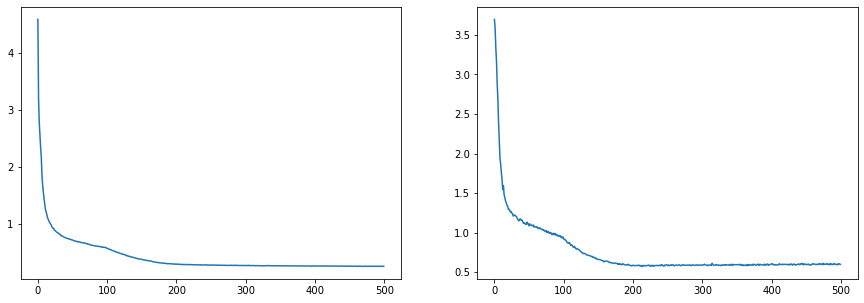

In [180]:
import matplotlib.pyplot as plt

optimizer = torch.optim.Adam(ANN.parameters(), lr=1e-3)
training_loss_total, validation_loss_total = [],[]
for t in range(500):
    loss_train, loss_val = train_double_embedding(ANN,optimizer,data_loader, data_loader_validation)
    training_loss_total.append(np.mean(loss_train))
    validation_loss_total.append(np.mean(loss_val))

fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(training_loss_total)
ax[1].plot(validation_loss_total)

plt.show()

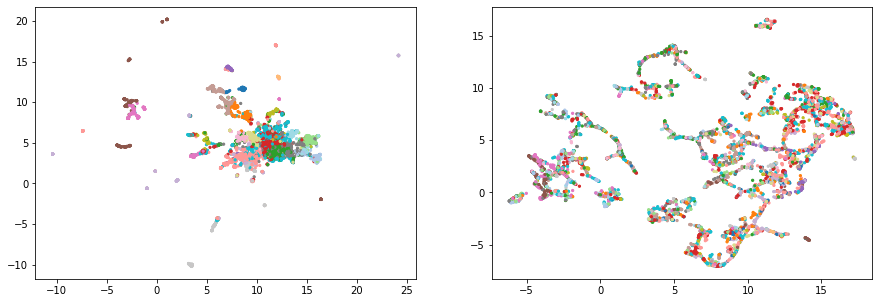

In [181]:
from umap import UMAP

ANN.eval()

y_test = y_test.drop_duplicates()
X_test = X_test.drop_duplicates()
common_index = [x for x in X_test.index if x in y_test.index]
X_test = X_test.loc[common_index,:]
y_test = y_test.loc[common_index,:]

emb_x, emb_y = ANN(torch.Tensor(X_test.to_numpy()).to(torch.float32),torch.Tensor(y_test.to_numpy()).to(torch.float32))

from sklearn.cluster import KMeans

km = KMeans(20)


emb_umap_y = UMAP().fit_transform(emb_y.detach().numpy())


labels = km.fit_predict(emb_y.detach().numpy())
emb_umap_x = UMAP().fit_transform(emb_x.detach().numpy(),labels)
fir,ax = plt.subplots(ncols=2,figsize=(15,5))

ax[0].scatter(emb_umap_y[:,0],emb_umap_y[:,1],c=labels,cmap="tab20",s=5)
ax[1].scatter(emb_umap_x[:,0],emb_umap_x[:,1],c=labels,cmap="tab20",s=5)

In [183]:
torch.save(ANN.state_dict(),"double_embedding_desmartines.pth")